In [1]:
import datetime as dt
import json
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pandas as pd
import random 
import regex
import seaborn as sns
import sklearn
import warnings
import gc
from scipy.stats import pearsonr
from itertools import product
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Desys_Group/data/'

Mounted at /content/drive


# Data Cleaning 

In [2]:
input_files = [
               root+'json_data_successful_LWV2ZW50X3RpbWVzdGFtcD0yMDIyLTA0LTE0KzE0JTNBNDIlM0EwMyYtcGs9NTAxNjgzODM4MQ==.csv',
               root+'json_data_successful_LWV2ZW50X3RpbWVzdGFtcD0yMDIyLTA0LTExKzIxJTNBNDMlM0EzOCYtcGs9NDkyODM5MDExMA==.csv',
               root+'json_data_bid_withdrawn_LWV2ZW50X3RpbWVzdGFtcD0yMDIyLTAzLTMwKzA2JTNBMDAlM0EyMCYtcGs9NDU3MzgwNzUwOQ==.csv',
               root+'json_data_bid_withdrawn_LWV2ZW50X3RpbWVzdGFtcD0yMDIyLTAzLTE0KzEwJTNBMTYlM0E1OSYtcGs9NDExMjk0MjkxMg==.csv',
              ]

event_df = pd.concat(map(pd.read_csv, input_files)).drop(columns=['Unnamed: 0'])
event_df = event_df[event_df['event/asset/asset_contract/asset_contract_type'] == 'non-fungible']
event_df = event_df.reset_index().drop(columns=['index'])
gc.collect()
display(event_df.head())
display(event_df.shape)

,event/asset/id,event/asset/num_sales,event/asset/image_url,event/asset/image_preview_url,event/asset/image_thumbnail_url,event/asset/image_original_url,event/asset/name,event/asset/description,event/asset/asset_contract/address,event/asset/asset_contract/asset_contract_type,...,event/dev_fee_payment_event/transaction/timestamp,event/dev_fee_payment_event/transaction/to_account/profile_img_url,event/dev_fee_payment_event/transaction/to_account/address,event/dev_fee_payment_event/transaction/transaction_hash,event/dev_fee_payment_event/transaction/transaction_index,event/dev_fee_payment_event/created_date,event/asset_bundle/asset_contract/collection/is_nsfw,event/asset/asset_contract/default_to_fiat,event/asset/collection/default_to_fiat,event/asset/decimals
0,368747125.0,7.0,https://lh3.googleusercontent.com/o3ApgRB8l7uT...,https://lh3.googleusercontent.com/o3ApgRB8l7uT...,https://lh3.googleusercontent.com/o3ApgRB8l7uT...,https://thinghide.oss-cn-hongkong.aliyuncs.com...,Mokai Salmon,It is said that there is such a person in ever...,0x7c9c6e39e6d1d539acc2ec1de5cc4ab30c6bfe0e,non-fungible,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,299238324.0,4.0,https://lh3.googleusercontent.com/3EAlagI_S--J...,https://lh3.googleusercontent.com/3EAlagI_S--J...,https://lh3.googleusercontent.com/3EAlagI_S--J...,https://catblox.mypinata.cloud/ipfs/QmQkd6zric...,CatBlox #8756,Welcome to the cute and pudgy world of CatBlox...,0x86c35fa9665002c08801805280ff6a077b23c98a,non-fungible,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,180290943.0,1.0,https://openseauserdata.com/files/69f893f76b3c...,https://storage.opensea.io/files/69f893f76b3cb...,https://storage.opensea.io/files/69f893f76b3cb...,NaN,Zorb #13362,Zorbs were distributed for free by ZORA on New...,0xca21d4228cdcc68d4e23807e5e370c07577dd152,non-fungible,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,346339296.0,2.0,https://lh3.googleusercontent.com/Gn9nws81odN2...,https://lh3.googleusercontent.com/Gn9nws81odN2...,https://lh3.googleusercontent.com/Gn9nws81odN2...,ipfs://QmZVHQdaTQLwq8m4isenJNwMTeQMWKM8NjCDk7c...,(B)APETAVERSE #2346,Conceptualized from the official A BATHING APE...,0x4addca4c07a5e9a6b4973094d03ad5aae7735e5b,non-fungible,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181713070.0,1.0,https://openseauserdata.com/files/69f893f76b3c...,https://storage.opensea.io/files/69f893f76b3cb...,https://storage.opensea.io/files/69f893f76b3cb...,NaN,Zorb #27797,Zorbs were distributed for free by ZORA on New...,0xca21d4228cdcc68d4e23807e5e370c07577dd152,non-fungible,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(396707, 185)

## Datetime Alignment

In [3]:
event_df['event/transaction/timestamp'] = pd.to_datetime(event_df['event/transaction/timestamp'])
successful_ts = event_df[event_df['event/event_type'] == 'successful']['event/transaction/timestamp']
withdrawn_ts = event_df[event_df['event/event_type'] == 'bid_withdrawn']['event/transaction/timestamp']
event_df = event_df[event_df['event/transaction/timestamp'] >= max(successful_ts.min(), withdrawn_ts.min())]
event_df = event_df[event_df['event/transaction/timestamp'] <= min(successful_ts.max(), withdrawn_ts.max())]
event_df = event_df.sort_values(by='event/transaction/timestamp')
print('After alignment:')
display(event_df['event/transaction/timestamp'].describe())

After alignment:


count                  368706
unique                  32042
top       2022-04-14 13:54:54
freq                      142
first     2022-04-11 21:43:38
last      2022-04-17 11:17:29
Name: event/transaction/timestamp, dtype: object

## Empty Rate

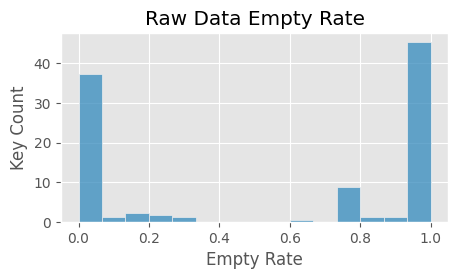

In [4]:
empty_rate = event_df.isnull().mean()
plt.figure(figsize=(5, 2.5), dpi=100);
sns.histplot(empty_rate, bins=15, stat='percent');
plt.title('Raw Data Empty Rate');
plt.ylabel('Key Count');
plt.xlabel('Empty Rate');

Full value keys

In [5]:
keys_full = event_df.loc[:, empty_rate == 0].keys().array
[print(k) for k in keys_full];

event/asset/id
event/asset/asset_contract/address
event/asset/asset_contract/asset_contract_type
event/asset/asset_contract/created_date
event/asset/asset_contract/name
event/asset/asset_contract/schema_name
event/asset/asset_contract/seller_fee_basis_points
event/asset/permalink
event/asset/collection/created_date
event/asset/collection/dev_buyer_fee_basis_points
event/asset/collection/dev_seller_fee_basis_points
event/asset/collection/safelist_request_status
event/asset/collection/name
event/asset/collection/opensea_buyer_fee_basis_points
event/asset/collection/opensea_seller_fee_basis_points
event/asset/collection/slug
event/asset/owner/profile_img_url
event/asset/owner/address
event/asset/token_id
event/collection_slug
event/contract_address
event/created_date
event/event_type
event/id
event/payment_token/symbol
event/payment_token/address
event/payment_token/image_url
event/payment_token/name
event/payment_token/decimals
event/payment_token/eth_price
event/payment_token/usd_price


Remove keys whose empty rate is above **0.25**

In [6]:
empty_rate = event_df.isnull().mean()
asset_threshold = 0.25
event_df_pruned = event_df.loc[:, empty_rate < asset_threshold]
print(f'Pruned shape: {event_df_pruned.shape}')

Pruned shape: (368706, 78)


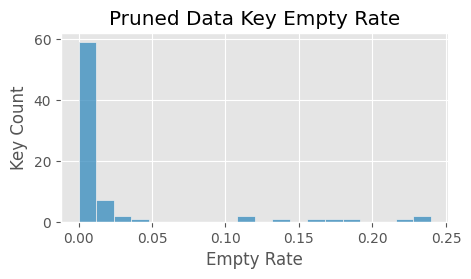

In [7]:

puned_empty_rate = event_df_pruned.isnull().mean()
plt.figure(figsize=(5, 2.5), dpi=100);
sns.histplot(puned_empty_rate, bins=20);
plt.title('Pruned Data Key Empty Rate');
plt.ylabel('Key Count');
plt.xlabel('Empty Rate');

## Popular Values

In [8]:
print(f'Total keys: {len(event_df_pruned.keys())}\n')

index = 0
for k in event_df_pruned.keys():
    print(f'{index}. {k}')
    num_unique = event_df_pruned[k].nunique()
    print(f'Num unique values: {num_unique:4d}')
    print(f'Empty rate:        {event_df_pruned[k].isna().mean():.2f}')
    print(f'Popular values:\n{event_df_pruned[k].value_counts().head(3)}\n')
    index = index + 1

Total keys: 78

0. event/asset/id
Num unique values: 309383
Empty rate:        0.00
Popular values:
381803879.0    550
381803882.0    341
381803888.0    153
Name: event/asset/id, dtype: int64

1. event/asset/num_sales
Num unique values:   23
Empty rate:        0.00
Popular values:
1.0    175180
2.0    106513
3.0     50269
Name: event/asset/num_sales, dtype: int64

2. event/asset/image_url
Num unique values: 232517
Empty rate:        0.00
Popular values:
https://lh3.googleusercontent.com/J2Sa4JgrFXUWYcRZre_kSZtyVqm5q5vnKydX5uXQjLiCW_lxysOLjbEpT6qDlwXf4_d15n0dYR2YxKFdNu56p4dDh07Vv2w_EYng       3984
https://lh3.googleusercontent.com/H467nvHL-TezOnjMRq2TMJcqX67GEs6cUYsexPSBoUPVEQnofKPzYDqnmQ3QWJaqH8P_emRHk3lRzYcNM4Z4ljpbeukUvb-bKg6rz2M    3373
https://lh3.googleusercontent.com/4OfIU1xa9R9zwKMVlfyDUemlGkfnYosX_IPDKlE1VYkPetCBPEho4W9GrH0TLubCBnNgO5ur9z363eAYx3WrTY5nAOJ12sS51gjDwg     3215
Name: event/asset/image_url, dtype: int64

3. event/asset/image_preview_url
Num unique values: 232514
Em

# Exploratory Data Analysis

## Univariate Analysis

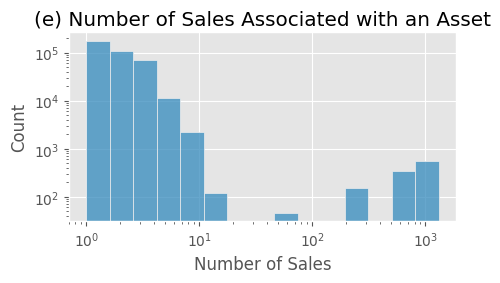

In [9]:
plt.figure(figsize=(5, 2.5), dpi=100);
hp = sns.histplot(event_df_pruned['event/asset/num_sales'] + 0.001, bins=15, log_scale=True);
hp.set_yscale('log');
plt.title('(e) Number of Sales Associated with an Asset');
plt.xlabel('Number of Sales');
plt.ylabel('Count');

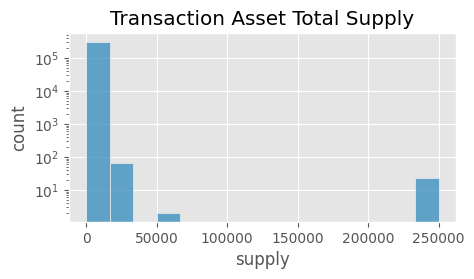

In [10]:
plt.figure(figsize=(5, 2.5), dpi=100);
hp = sns.histplot(event_df_pruned['event/asset/asset_contract/total_supply'].dropna().astype(int), bins=15);
hp.set_yscale('log');
plt.title('Transaction Asset Total Supply');
plt.xlabel('supply');
plt.ylabel('count');

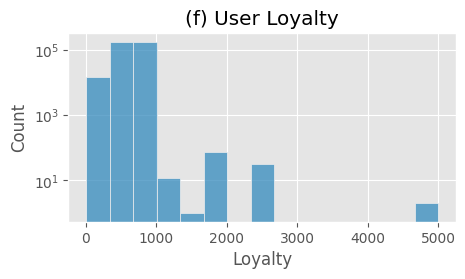

In [11]:
plt.figure(figsize=(5, 2.5), dpi=100);
hp = sns.histplot(event_df_pruned['event/asset/asset_contract/dev_seller_fee_basis_points'].dropna().astype(int), bins=15);
hp.set_yscale('log');
plt.title('(f) User Loyalty');
plt.xlabel('Loyalty');
plt.ylabel('Count');

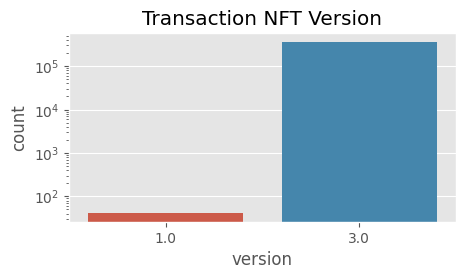

In [12]:
plt.figure(figsize=(5, 2.5), dpi=100);
cp = sns.countplot(event_df_pruned['event/asset/asset_contract/nft_version']);
cp.set_yscale('log');
plt.title('Transaction NFT Version');
plt.xlabel('version');

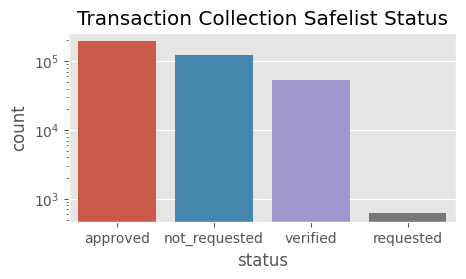

In [13]:
plt.figure(figsize=(5, 2.5), dpi=100);
cp = sns.countplot(event_df_pruned['event/asset/collection/safelist_request_status']);
cp.set_yscale('log');
plt.title('Transaction Collection Safelist Status');
plt.xlabel('status');

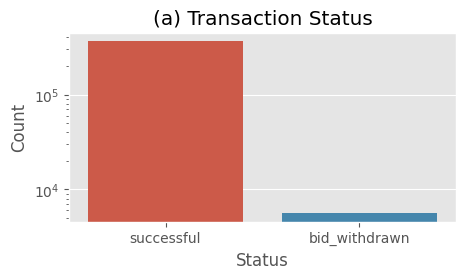

In [14]:
plt.figure(figsize=(5, 2.5), dpi=100);
cp = sns.countplot(event_df_pruned['event/event_type']);
cp.set_yscale('log');
plt.title('(a) Transaction Status');
plt.xlabel('Status');
plt.ylabel('Count');

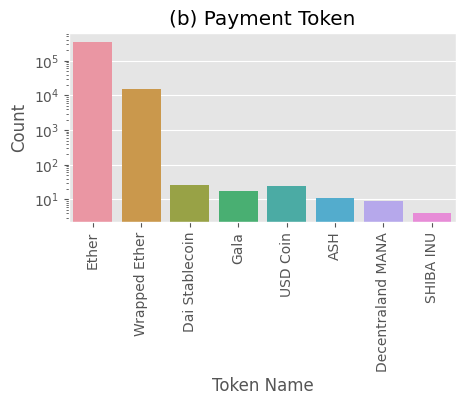

In [15]:
plt.figure(figsize=(5, 2.5), dpi=100);
cp = sns.countplot(event_df_pruned['event/payment_token/name']);
cp.set_yscale('log');
plt.title('(b) Payment Token');
plt.xlabel('Token Name');
plt.ylabel('Count');
plt.xticks(rotation = 90);

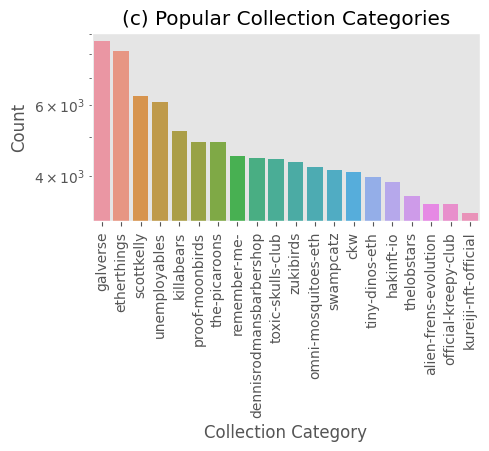

In [16]:
plt.figure(figsize=(5, 2.5), dpi=100);
pop_collections = event_df_pruned['event/collection_slug'].value_counts()[:20]
bp = sns.barplot(x=pop_collections.keys(), y=pop_collections.values);
bp.set_yscale('log');
plt.title('(c) Popular Collection Categories');
plt.xlabel('Collection Category');
plt.ylabel('Count');
plt.xticks(rotation = 90);

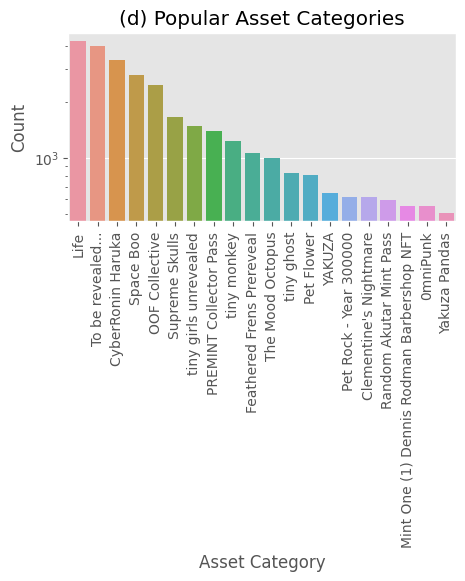

In [17]:
plt.figure(figsize=(5, 2.5), dpi=100);
pop_assets = event_df_pruned['event/asset/name'].value_counts()[:20]
bp = sns.barplot(x=pop_assets.keys(), y=pop_assets.values);
bp.set_yscale('log');
plt.title('(d) Popular Asset Categories');
plt.xlabel('Asset Category');
plt.ylabel('Count');
plt.xticks(rotation = 90);

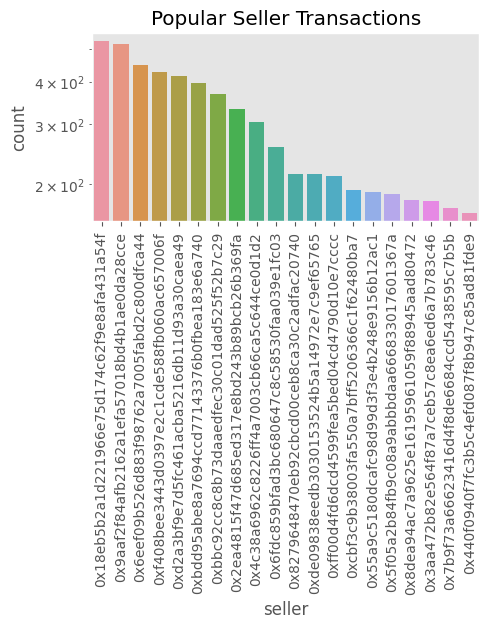

In [18]:
plt.figure(figsize=(5, 2.5), dpi=100);
pop_sellers = event_df_pruned['event/transaction/from_account/address'].value_counts()[:20]
bp = sns.barplot(x=pop_sellers.keys(), y=pop_sellers.values);
bp.set_yscale('log');
plt.title('Popular Seller Transactions');
plt.xlabel('seller');
plt.ylabel('count');
plt.xticks(rotation = 90);

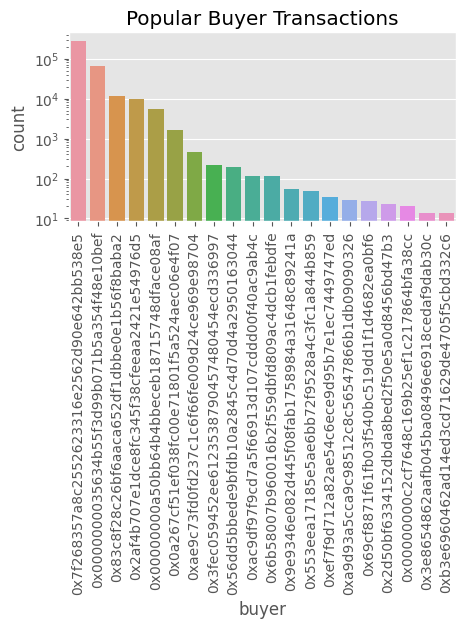

In [19]:
plt.figure(figsize=(5, 2.5), dpi=100);
pop_buyers = event_df_pruned['event/transaction/to_account/address'].value_counts()[:20]
bp = sns.barplot(x=pop_buyers.keys(), y=pop_buyers.values);
bp.set_yscale('log');
plt.title('Popular Buyer Transactions');
plt.xlabel('buyer');
plt.ylabel('count');
plt.xticks(rotation = 90);

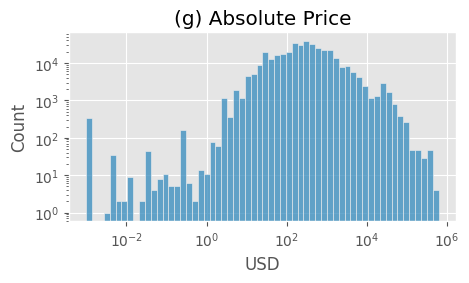

In [20]:
def find_absolute_price(df):
    df['absolute_price'] = df['event/total_price'].astype(float) / (10 ** df['event/payment_token/decimals']).astype(float) \
    * df['event/payment_token/eth_price'].astype(float) * df['event/payment_token/usd_price'].astype(float) + 0.001

find_absolute_price(event_df_pruned)
plt.figure(figsize=(5, 2.5), dpi=100)
hp = sns.histplot(event_df_pruned['absolute_price'], log_scale=True, bins=60);
hp.set_yscale('log');
plt.title('(g) Absolute Price');
plt.xlabel('USD');
plt.ylabel('Count');

## Pairwise Correlation

Feature Matrix

In [21]:
selected_keys = {
                 'event/asset/name' : [str, 'asset_name'],
                 'event/asset/id' : [str, 'asset_id'],
                 'event/asset/num_sales' : [float, 'num_sales'],
                 'event/asset/asset_contract/created_date' : ['datetime64[ns]', 'asset_created_date'],
                 'event/asset/asset_contract/symbol' : [str, 'contract_type'],
                 'event/asset/asset_contract/nft_version' : [str, 'nft_version'],
                 'event/asset/collection/created_date' : ['datetime64[ns]', 'collection_created_date'],
                 'event/asset/collection/safelist_request_status' : [str, 'safelist'],
                 'event/asset/collection/dev_seller_fee_basis_points' : [float, 'collection_loyalty'],
                 'event/collection_slug' : [str, 'collection_slug'],
                 'event/transaction/from_account/address' : [str, 'from_addr'],
                 'event/transaction/to_account/address' : [str, 'to_addr'],
                 'event/dev_seller_fee_basis_points' : [float, 'asset_loyality'],
                 'event/event_type' : [str, 'event_type'],
                 'event/id' : [str, 'event_id'],
                 'event/payment_token/name' : [str, 'payment_type'],
                 'event/payment_token/decimals' : [float, 'price_decimal'],
                 'event/payment_token/eth_price' : [float, 'eth_price'],
                 'event/payment_token/usd_price' : [float, 'usd_price'],
                 'event/total_price' : [float, 'tot_price'],
                 'event/transaction/timestamp' : ['datetime64[ns]', 'transaction_timestamp'],
                 'absolute_price' : [float, 'absolute_price'],
                 'event/asset/image_thumbnail_url' : [str, 'image_url'],
                }

datetime_keys = [
                 'asset_created_date',
                 'collection_created_date',
                 'transaction_timestamp',
                ]

identifier_keys = [
                   'asset_name',
                   'collection_slug',
                   'event_id',
                   'asset_id',
                   'image_url',
                  ]

feature_matrix = event_df_pruned[selected_keys.keys()]
for key, val in selected_keys.items():
    feature_matrix[key] = feature_matrix[key].astype(val[0])
    feature_matrix.rename(columns={key:val[1]}, inplace=True)

# feature_matrix['event_type'] = (feature_matrix['event_type'] == 'successful').astype(int)
display(feature_matrix.shape)
print('Feature Matrix Keys:')
display(feature_matrix.dtypes)
display(feature_matrix.head())

(368706, 23)

Feature Matrix Keys:


asset_name                         object
asset_id                           object
num_sales                         float64
asset_created_date         datetime64[ns]
contract_type                      object
nft_version                        object
collection_created_date    datetime64[ns]
safelist                           object
collection_loyalty                float64
collection_slug                    object
from_addr                          object
to_addr                            object
asset_loyality                    float64
event_type                         object
event_id                           object
payment_type                       object
price_decimal                     float64
eth_price                         float64
usd_price                         float64
tot_price                         float64
transaction_timestamp      datetime64[ns]
absolute_price                    float64
image_url                          object
dtype: object

,asset_name,asset_id,num_sales,asset_created_date,contract_type,nft_version,collection_created_date,safelist,collection_loyalty,collection_slug,...,event_type,event_id,payment_type,price_decimal,eth_price,usd_price,tot_price,transaction_timestamp,absolute_price,image_url
363104,Chum Chums #993,347090691.0,1.0,2022-03-22 03:35:02.219128,CHUMCHUMS,3.0,2022-03-22 18:15:54.333231,approved,600.0,chumchumsnft,...,successful,4928390110,Ether,18.0,1.0,3019.07,8.000000e+16,2022-04-11 21:43:38,241.526600,https://lh3.googleusercontent.com/IlCMJrHDR_oC...
363085,Froyo Kittens #1579,377916866.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,successful,4928999853,Ether,18.0,1.0,3019.07,2.900000e+17,2022-04-11 21:43:38,875.531300,https://lh3.googleusercontent.com/SsA4B7yPZUt2...
363086,Froyo Kittens #2313,377955530.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,successful,4928999727,Ether,18.0,1.0,3019.07,2.842000e+17,2022-04-11 21:43:38,858.020694,https://lh3.googleusercontent.com/uV0kmKNIfieD...
363087,Froyo Kittens #7474,380432265.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,successful,4928999578,Ether,18.0,1.0,3019.07,2.900000e+17,2022-04-11 21:43:38,875.531300,https://lh3.googleusercontent.com/EJSrHw2ui1NM...
363088,Froyo Kittens #7722,380598367.0,2.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,successful,4928999435,Ether,18.0,1.0,3019.07,2.846000e+17,2022-04-11 21:43:38,859.228322,https://lh3.googleusercontent.com/HuYJiPisbdju...


Correlation

<Figure size 800x800 with 0 Axes>

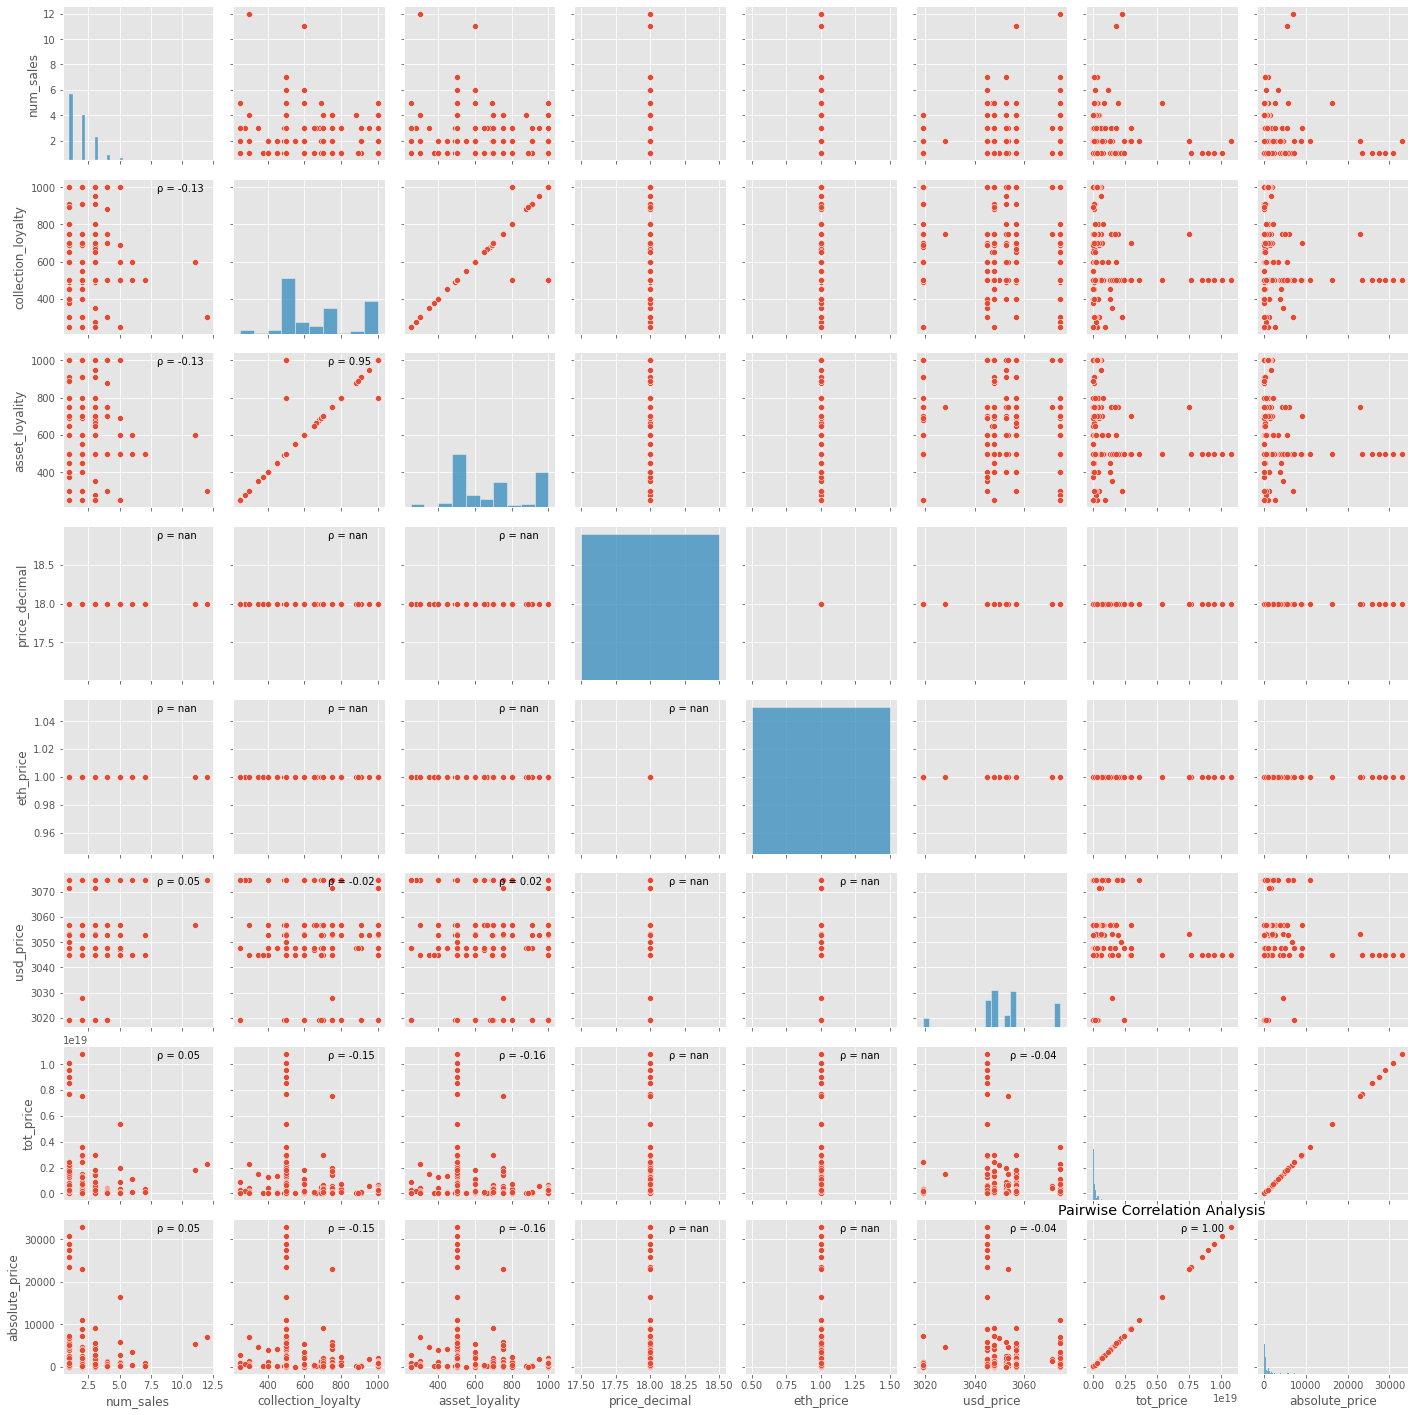

In [22]:
def corrfunc(x, y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca();
    ax.annotate(f'ρ = {r:.2f}', xy=(.625, .925), xycoords=ax.transAxes);

quantitive_matrix = feature_matrix.dropna().drop(columns=datetime_keys + identifier_keys)
plt.figure(figsize=(8, 8), dpi=100);
pg = sns.pairplot(quantitive_matrix.sample(500, random_state=7));
pg.map_lower(corrfunc);
plt.title('Pairwise Correlation Analysis');

## Bivariate Analysis

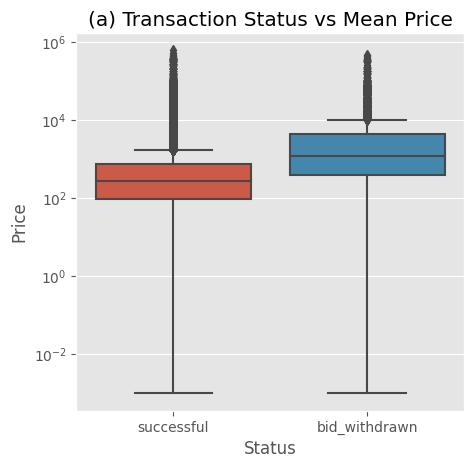

In [23]:
plt.figure(figsize=(5, 5), dpi=100);
to_plot = feature_matrix
sns.boxplot(data=to_plot, x='event_type', y='absolute_price');
plt.yscale('log');
plt.xlabel('Status');
plt.ylabel('Price');
plt.title('(a) Transaction Status vs Mean Price');

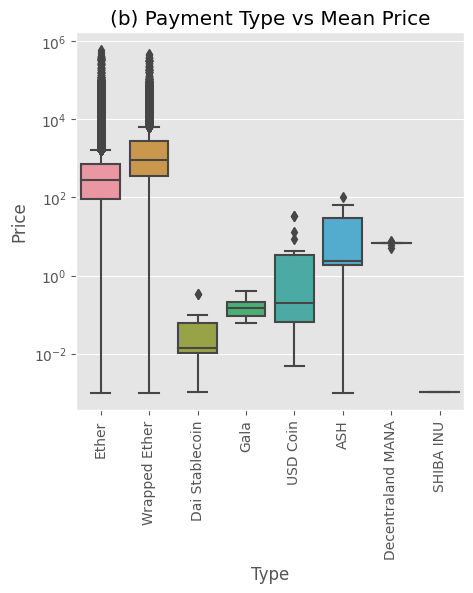

In [24]:
plt.figure(figsize=(5, 5), dpi=100);
to_plot = feature_matrix
sns.boxplot(data=to_plot, x='payment_type', y='absolute_price');
plt.yscale('log');
plt.xlabel('Type');
plt.ylabel('Price');
plt.title('(b) Payment Type vs Mean Price');
plt.xticks(rotation = 90);

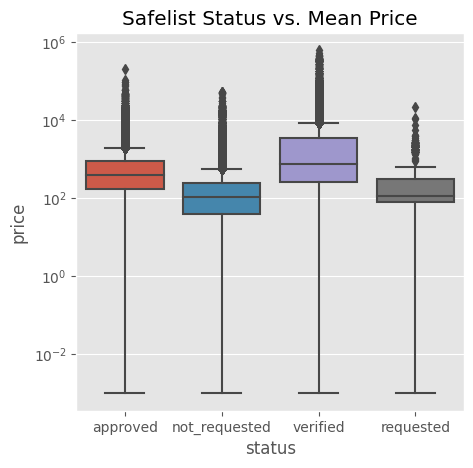

In [25]:
plt.figure(figsize=(5, 5), dpi=100);
to_plot = feature_matrix
sns.boxplot(data=to_plot, x='safelist', y='absolute_price');
plt.yscale('log');
plt.xlabel('status');
plt.ylabel('price');
plt.title('Safelist Status vs. Mean Price');

## Multivariate Analysis

,asset_name,asset_id,num_sales,asset_created_date,contract_type,nft_version,collection_created_date,safelist,collection_loyalty,collection_slug,...,payment_type,price_decimal,eth_price,usd_price,tot_price,transaction_timestamp,absolute_price,image_url,transaction_timestamp_h,count
363104,Chum Chums #993,347090691.0,1.0,2022-03-22 03:35:02.219128,CHUMCHUMS,3.0,2022-03-22 18:15:54.333231,approved,600.0,chumchumsnft,...,Ether,18.0,1.0,3019.07,8.000000e+16,2022-04-11 21:43:38,241.526600,https://lh3.googleusercontent.com/IlCMJrHDR_oC...,2022-04-11 21:00:00,1
363085,Froyo Kittens #1579,377916866.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,Ether,18.0,1.0,3019.07,2.900000e+17,2022-04-11 21:43:38,875.531300,https://lh3.googleusercontent.com/SsA4B7yPZUt2...,2022-04-11 21:00:00,1
363086,Froyo Kittens #2313,377955530.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,Ether,18.0,1.0,3019.07,2.842000e+17,2022-04-11 21:43:38,858.020694,https://lh3.googleusercontent.com/uV0kmKNIfieD...,2022-04-11 21:00:00,1
363087,Froyo Kittens #7474,380432265.0,1.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,Ether,18.0,1.0,3019.07,2.900000e+17,2022-04-11 21:43:38,875.531300,https://lh3.googleusercontent.com/EJSrHw2ui1NM...,2022-04-11 21:00:00,1
363088,Froyo Kittens #7722,380598367.0,2.0,2022-04-07 00:12:53.932530,FroyoKitten,3.0,2022-04-07 23:58:56.873286,approved,500.0,froyokittenscollection,...,Ether,18.0,1.0,3019.07,2.846000e+17,2022-04-11 21:43:38,859.228322,https://lh3.googleusercontent.com/HuYJiPisbdju...,2022-04-11 21:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Zorb #27797,181713070.0,1.0,2022-01-01 03:36:17.805929,ZORB,3.0,2022-01-01 05:00:25.215349,not_requested,0.0,zorbs-v2,...,Ether,18.0,1.0,3044.98,9.800000e+15,2022-04-17 11:17:29,29.841804,https://storage.opensea.io/files/69f893f76b3cb...,2022-04-17 11:00:00,1
3,(B)APETAVERSE #2346,346339296.0,2.0,2022-03-22 07:12:10.979516,BVS,3.0,2022-03-22 09:16:10.103849,approved,750.0,bapetaverse-official,...,Ether,18.0,1.0,3044.98,6.500000e+17,2022-04-17 11:17:29,1979.238000,https://lh3.googleusercontent.com/Gn9nws81odN2...,2022-04-17 11:00:00,1
2,Zorb #13362,180290943.0,1.0,2022-01-01 03:36:17.805929,ZORB,3.0,2022-01-01 05:00:25.215349,not_requested,0.0,zorbs-v2,...,Ether,18.0,1.0,3044.98,9.800000e+15,2022-04-17 11:17:29,29.841804,https://storage.opensea.io/files/69f893f76b3cb...,2022-04-17 11:00:00,1
1,CatBlox #8756,299238324.0,4.0,2022-02-15 03:57:07.894865,CATBLOXGEN,3.0,2022-02-15 19:15:33.655423,approved,750.0,catbloxgenesis,...,Wrapped Ether,18.0,1.0,3045.04,1.352000e+17,2022-04-17 11:17:29,411.690408,https://lh3.googleusercontent.com/3EAlagI_S--J...,2022-04-17 11:00:00,1


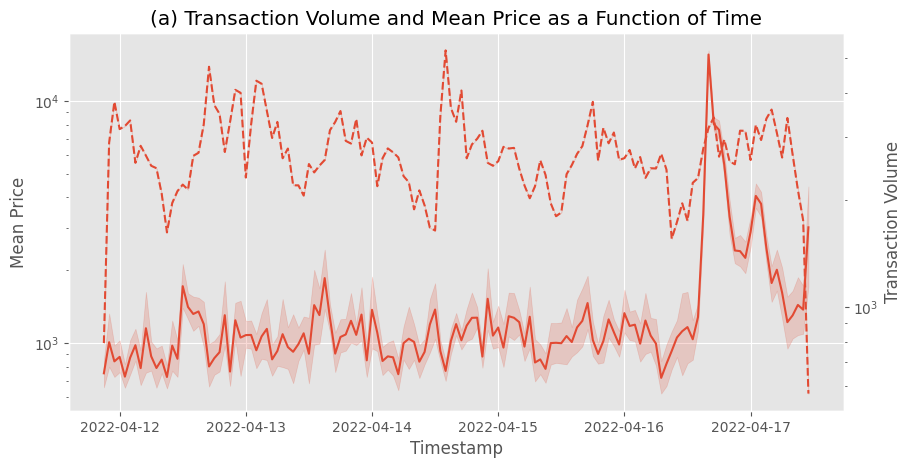

In [26]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
to_plot['count'] = 1
display(to_plot)
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='absolute_price');
plt.ylabel('Mean Price');
plt.xlabel('Timestamp');
plt.yscale('log');
plt.title('(a) Transaction Volume and Mean Price as a Function of Time');
ax2 = plt.twinx();
ax2.grid(False);
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='count', linestyle='--', estimator='sum', ax=ax2);
ax2.set_ylabel('Transaction Volume');
ax2.set_yscale('log');

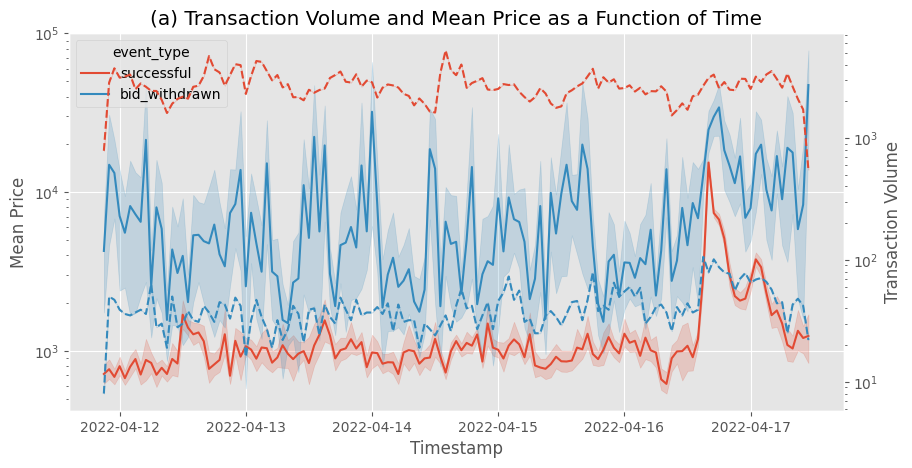

In [27]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
to_plot['count'] = 1
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='absolute_price', hue='event_type', estimator='mean');
plt.ylabel('Mean Price');
plt.xlabel('Timestamp');
plt.title('(a) Transaction Volume and Mean Price as a Function of Time');
plt.yscale('log');
ax2 = plt.twinx();
ax2.grid(False);
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='count', linestyle='--', hue='event_type', estimator='sum', ax=ax2);
ax2.get_legend().remove();
ax2.set_ylabel('Transaction Volume');
ax2.set_yscale('log');

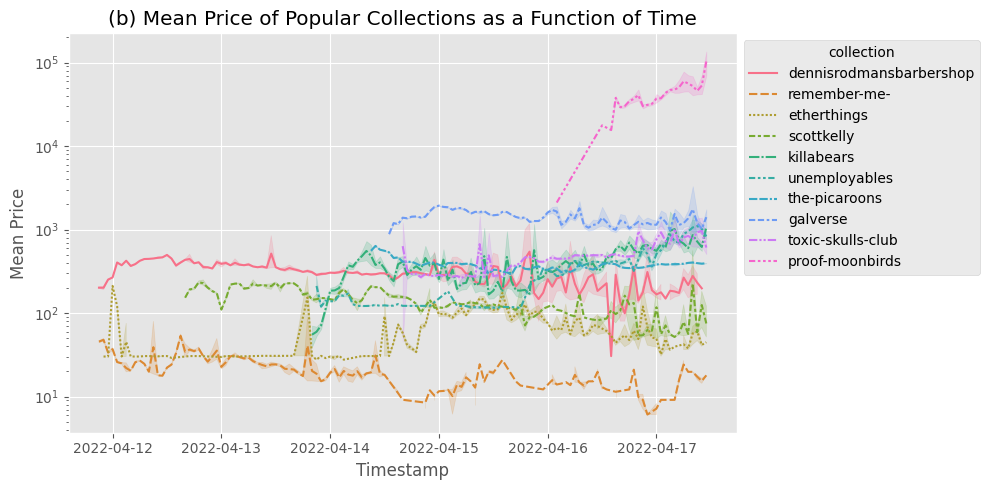

In [28]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix[feature_matrix['collection_slug'].isin(pop_collections.keys()[:10])]
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='absolute_price', style='collection_slug', hue='collection_slug');
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='collection');
plt.ylabel('Mean Price');
plt.xlabel('Timestamp');
plt.title('(b) Mean Price of Popular Collections as a Function of Time');
plt.yscale('log');
plt.tight_layout();

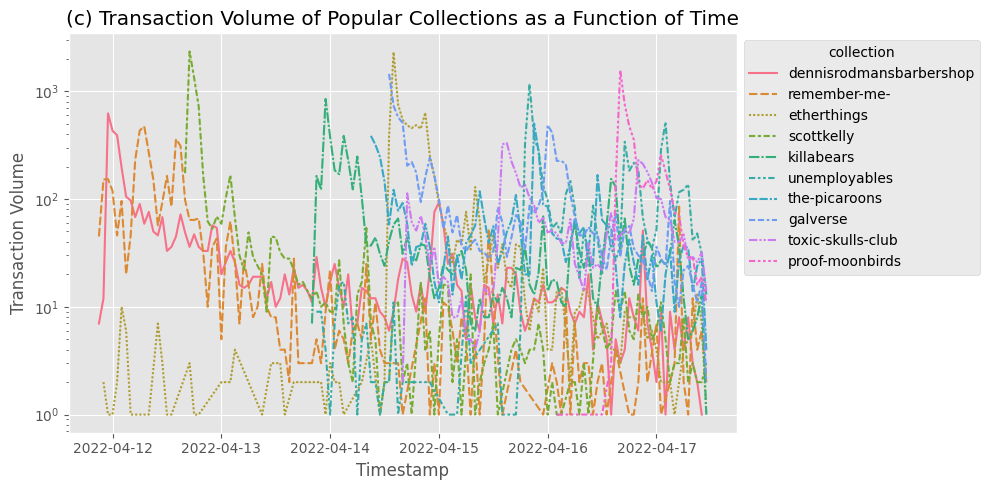

In [29]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix[feature_matrix['collection_slug'].isin(pop_collections.keys()[:10])]
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
to_plot['count'] = 1
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='count', style='collection_slug', hue='collection_slug', estimator='sum');
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='collection');
plt.ylabel('Transaction Volume');
plt.xlabel('Timestamp');
plt.title('(c) Transaction Volume of Popular Collections as a Function of Time');
plt.yscale('log');
plt.tight_layout();

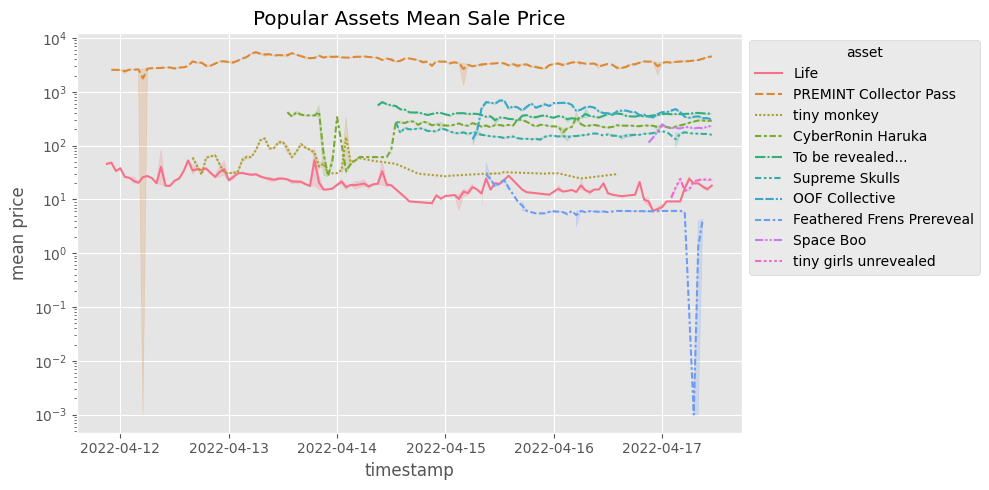

In [30]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix[feature_matrix['asset_name'].isin(pop_assets.keys()[:10])]
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='absolute_price', style='asset_name', hue='asset_name');
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='asset');
plt.ylabel('mean price');
plt.xlabel('timestamp');
plt.title('Popular Assets Mean Sale Price');
plt.yscale('log');
plt.tight_layout();

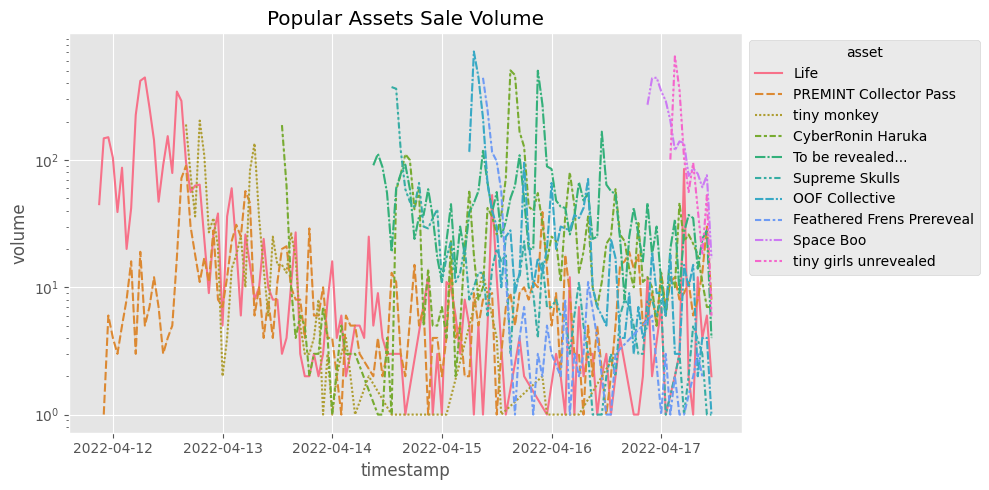

In [31]:
plt.figure(figsize=(10, 5), dpi=100)
to_plot = feature_matrix[feature_matrix['asset_name'].isin(pop_assets.keys()[:10])]
to_plot['transaction_timestamp_h'] = to_plot['transaction_timestamp'].dt.floor('h')
to_plot['count'] = 1
sns.lineplot(data=to_plot, x='transaction_timestamp_h', y='count', style='asset_name', hue='asset_name', estimator='sum');
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='asset');
plt.ylabel('volume');
plt.xlabel('timestamp');
plt.title('Popular Assets Sale Volume');
plt.yscale('log');
plt.tight_layout();

# Naive Matrix (Transaction-Based)

In [32]:
to_remove = [
             'asset_id',
             'asset_created_date',
             'collection_created_date',
             'transaction_timestamp',
             'transaction_timestamp_h'
            ]

after_remove = feature_matrix.drop(columns=to_remove).dropna()
after_remove.to_csv(root+'naive_matrix.csv')
after_remove.head()

,asset_name,num_sales,contract_type,nft_version,safelist,collection_loyalty,collection_slug,from_addr,to_addr,asset_loyality,event_type,event_id,payment_type,price_decimal,eth_price,usd_price,tot_price,absolute_price,image_url,count
363104,Chum Chums #993,1.0,CHUMCHUMS,3.0,approved,600.0,chumchumsnft,0xc58a54ac5e910c818ccf40ccbbde0c6e5e1da27f,0x0000000035634b55f3d99b071b5a354f48e10bef,600.0,successful,4928390110,Ether,18.0,1.0,3019.07,8.000000e+16,241.526600,https://lh3.googleusercontent.com/IlCMJrHDR_oC...,1
363085,Froyo Kittens #1579,1.0,FroyoKitten,3.0,approved,500.0,froyokittenscollection,0x326ef9fa575a92090d8dea0b1f053afca64fb19b,0x0000000035634b55f3d99b071b5a354f48e10bef,500.0,successful,4928999853,Ether,18.0,1.0,3019.07,2.900000e+17,875.531300,https://lh3.googleusercontent.com/SsA4B7yPZUt2...,1
363086,Froyo Kittens #2313,1.0,FroyoKitten,3.0,approved,500.0,froyokittenscollection,0x326ef9fa575a92090d8dea0b1f053afca64fb19b,0x0000000035634b55f3d99b071b5a354f48e10bef,500.0,successful,4928999727,Ether,18.0,1.0,3019.07,2.842000e+17,858.020694,https://lh3.googleusercontent.com/uV0kmKNIfieD...,1
363087,Froyo Kittens #7474,1.0,FroyoKitten,3.0,approved,500.0,froyokittenscollection,0x326ef9fa575a92090d8dea0b1f053afca64fb19b,0x0000000035634b55f3d99b071b5a354f48e10bef,500.0,successful,4928999578,Ether,18.0,1.0,3019.07,2.900000e+17,875.531300,https://lh3.googleusercontent.com/EJSrHw2ui1NM...,1
363088,Froyo Kittens #7722,2.0,FroyoKitten,3.0,approved,500.0,froyokittenscollection,0x326ef9fa575a92090d8dea0b1f053afca64fb19b,0x0000000035634b55f3d99b071b5a354f48e10bef,500.0,successful,4928999435,Ether,18.0,1.0,3019.07,2.846000e+17,859.228322,https://lh3.googleusercontent.com/HuYJiPisbdju...,1
